In [1435]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
import datetime as dt
import pyarrow
import random
import datetime

In [1436]:
# from tensorflow.python.keras.models import Sequential
# from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
# from tensorflow.python.keras.optimizers import rmsprop_v2
# from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
# from tensorflow.python.keras.backend import square, mean
# from tensorflow.python.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization, GRU
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.optimizers import RMSprop


In [1437]:
df = pl.read_csv("~\Downloads\Chase9626_Activity_20230128.csv")
print(df)

shape: (1136, 7)
┌─────────┬──────────────┬──────────────────────┬─────────┬────────────┬─────────┬─────────────────┐
│ Details ┆ Posting Date ┆ Description          ┆ Amount  ┆ Type       ┆ Balance ┆ Check or Slip # │
│ ---     ┆ ---          ┆ ---                  ┆ ---     ┆ ---        ┆ ---     ┆ ---             │
│ str     ┆ str          ┆ str                  ┆ f64     ┆ str        ┆ f64     ┆ str             │
╞═════════╪══════════════╪══════════════════════╪═════════╪════════════╪═════════╪═════════════════╡
│ DEBIT   ┆ 01/27/2023   ┆ TOMMYS 18 WACO TX    ┆ -3.56   ┆ DEBIT_CARD ┆ 44.61   ┆ null            │
│         ┆              ┆ ...                  ┆         ┆            ┆         ┆                 │
│ DEBIT   ┆ 01/27/2023   ┆ BUC-EE'S #39 DENTON  ┆ -29.72  ┆ DEBIT_CARD ┆ 48.17   ┆ null            │
│         ┆              ┆ TX          ...      ┆         ┆            ┆         ┆                 │
│ DEBIT   ┆ 01/27/2023   ┆ CAPPUCCINO ITALIAN   ┆ -40.0   ┆ DEBIT_CARD ┆ 7

In [1438]:
only=df[["Amount","Posting Date"]]
categories=["food","shopping","bills","savings","entertainment"]
filt=only.filter(pl.col("Amount") < 0)
clean=filt.with_columns(pl.col("Posting Date").str.strptime(pl.Datetime, fmt="%m/%d/%Y"))
clean1=clean.with_columns(pl.col("Amount").apply(lambda x: x*-1))
clean2=clean1.groupby("Posting Date").agg(pl.col("Amount").sum()).sort("Posting Date",reverse=False)
randomlist = []
for i in range(0,len(clean2)):
    n = random.randint(0,4)
    randomlist.append(categories[n])
clean22=clean2.with_columns(pl.Series(name="Categories",values=randomlist))



Posting Date,Amount,Categories
datetime[μs],f64,str
2021-01-28 00:00:00,2.7,"""shopping"""
2021-01-29 00:00:00,6.74,"""savings"""
2021-02-01 00:00:00,51.83,"""shopping"""
2021-02-04 00:00:00,2.7,"""food"""
2021-02-05 00:00:00,12.07,"""bills"""
2021-02-08 00:00:00,14.95,"""savings"""
2021-02-09 00:00:00,2.7,"""savings"""
2021-02-10 00:00:00,7.44,"""bills"""
2021-02-12 00:00:00,3.49,"""bills"""


In [1439]:
def cleaning(data,cat):
    clean23=data.filter(pl.col("Categories")==cat)
    return clean23

In [1440]:
clean23=cleaning(clean22,"entertainment")
clean24=clean23.drop("Categories")

In [1442]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return dt.datetime(year=year, month=month, day=day)

In [1443]:
def df_to_windowed_df(dataframe, n): 
    clean3=dataframe
    
    for x in range(1,n+1):
        clean3=clean3.with_columns((pl.col("Amount").shift(x)).alias("Date-"+str(x)))
    ret_df=clean3[n:len(clean3),:]
    return ret_df
windowed_df = df_to_windowed_df(clean24,n=7)


Posting Date,Amount,Date-1,Date-2,Date-3,Date-4,Date-5,Date-6,Date-7
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2021-05-26 00:00:00,1.34,6.21,49.17,2.7,104.31,15.24,4.85,29.59
2021-06-07 00:00:00,43.48,1.34,6.21,49.17,2.7,104.31,15.24,4.85
2021-06-14 00:00:00,41.22,43.48,1.34,6.21,49.17,2.7,104.31,15.24
2021-06-17 00:00:00,4.87,41.22,43.48,1.34,6.21,49.17,2.7,104.31
2021-07-02 00:00:00,6.0,4.87,41.22,43.48,1.34,6.21,49.17,2.7
2021-08-19 00:00:00,417.8,6.0,4.87,41.22,43.48,1.34,6.21,49.17
2021-08-27 00:00:00,250.0,417.8,6.0,4.87,41.22,43.48,1.34,6.21
2021-10-20 00:00:00,12.6,250.0,417.8,6.0,4.87,41.22,43.48,1.34
2021-11-23 00:00:00,38.43,12.6,250.0,417.8,6.0,4.87,41.22,43.48


In [1444]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:,0]

    middle_matrix = df_as_np[:,2:]
    #X = middle_matrix.reshape((len(dates),middle_matrix.shape[1],1))
    X=middle_matrix
    Y = df_as_np[:,1]

    return dates, X.astype(np.float32), Y.astype(np.float32)
dates, X, y = windowed_df_to_date_X_y(windowed_df)


((53,), (53, 7), (53,))

In [1447]:
num_data = len(X)
train_split = 0.9
num_train = int(train_split * num_data)
num_test = num_data - num_train
x_train = X[0:num_train]
x_test = X[num_train:]
len(x_train) + len(x_test)

53

In [1448]:
y_train = y[0:num_train]
y_test = y[num_train:]
len(y_train) + len(y_test)

53

In [1449]:
num_x_signals = X.shape[1]
num_y_signals = 1

In [1451]:
x_scaler = MinMaxScaler()

In [1452]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [1454]:
x_test_scaled = x_scaler.transform(x_test)

In [1455]:
y_train1=y_train.reshape(-1,1)

[[  1.34]
 [ 43.48]
 [ 41.22]
 [  4.87]
 [  6.  ]
 [417.8 ]
 [250.  ]
 [ 12.6 ]
 [ 38.43]
 [ 33.29]
 [127.53]
 [ 79.85]
 [159.75]
 [  2.  ]
 [ 50.  ]
 [ 54.72]
 [ 24.18]
 [100.52]
 [ 44.05]
 [ 32.71]
 [ 51.54]
 [ 14.99]
 [  9.17]
 [ 28.96]
 [ 28.16]
 [  8.71]
 [ 35.44]
 [  3.45]
 [ 12.21]
 [ 35.73]
 [ 23.03]
 [214.73]
 [  4.24]
 [  2.  ]
 [181.86]
 [ 14.31]
 [161.66]
 [ 51.67]
 [  9.42]
 [ 35.  ]
 [  5.82]
 [ 38.09]
 [  7.81]
 [186.77]
 [ 33.41]
 [ 16.13]
 [  3.24]]


In [1456]:
y_train1=y_train.reshape(-1,1)
y_test1=y_test.reshape(-1,1)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train1)
y_test_scaled = y_scaler.transform(y_test1)

In [1457]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [1458]:
batch_size = 256
sequence_length = 20

In [1459]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [1460]:
x_batch, y_batch = next(generator)

In [1461]:
print(x_batch.shape)
print(y_batch.shape)

(256, 20, 7)
(256, 20, 1)


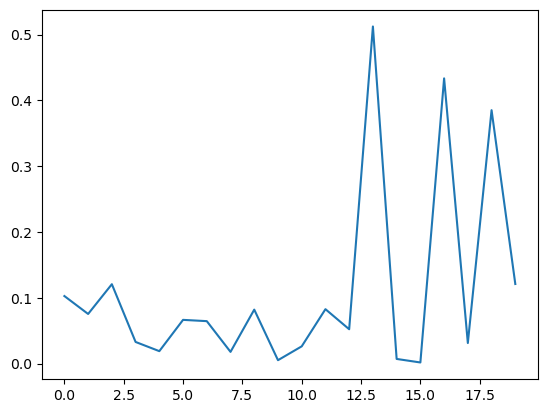

In [1462]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

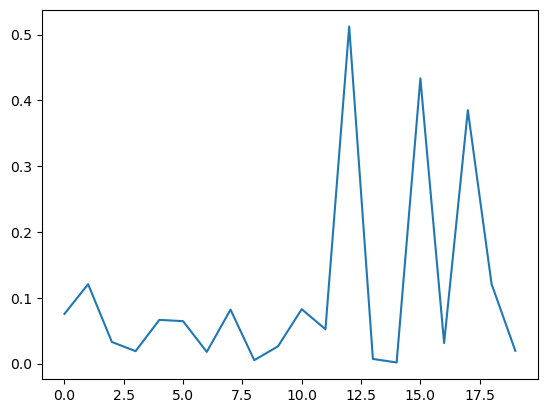

In [1463]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [1464]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [1465]:
model = Sequential()

In [1466]:
model.add(GRU(units=256,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [1467]:
# model.add(Dense(num_y_signals, activation='sigmoid'))

In [1468]:
from tensorflow.python.keras.initializers import RandomNormal

    # Maybe use lower init-ranges.
init = RandomNormal(mean=0, stddev=0.03)

model.add(Dense(num_y_signals,
                activation='relu',
                kernel_initializer=init))

In [1469]:
warmup_steps = 10

In [1471]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)

In [1472]:
model.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=1e-3))

In [1473]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_19 (GRU)                (None, None, 256)         203520    
                                                                 
 dense_25 (Dense)            (None, None, 1)           257       
                                                                 
Total params: 203,777
Trainable params: 203,777
Non-trainable params: 0
_________________________________________________________________


In [1474]:
# path_checkpoint = '23_checkpoint.keras'
# callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
#                                       monitor='val_loss',
#                                       verbose=1,
#                                       save_weights_only=True,
#                                       save_best_only=True)

In [1475]:
# callback_early_stopping = EarlyStopping(monitor='val_loss',
#                                         patience=5, verbose=1)

In [1476]:
# callback_tensorboard = TensorBoard(log_dir='./23_logs/',
#                                    histogram_freq=0,
                                #    write_graph=False)

In [1477]:
# callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
#                                        factor=0.1,
#                                        min_lr=1e-4,
#                                        patience=0,
#                                        verbose=1)

In [1478]:
# callbacks = [callback_early_stopping,
#              callback_checkpoint,
#              callback_tensorboard,
#              callback_reduce_lr]

In [1479]:
%%time
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data)

Epoch 1/20
100/100 [==============================] - 3s 13ms/step - loss: 0.0218 - val_loss: 0.0358
Epoch 2/20
100/100 [==============================] - 1s 9ms/step - loss: 0.0130 - val_loss: 0.0311
Epoch 3/20
100/100 [==============================] - 1s 9ms/step - loss: 0.0094 - val_loss: 0.0201
Epoch 4/20
100/100 [==============================] - 1s 9ms/step - loss: 0.0077 - val_loss: 0.0241
Epoch 5/20
100/100 [==============================] - 1s 9ms/step - loss: 0.0064 - val_loss: 0.0217
Epoch 6/20
100/100 [==============================] - 1s 9ms/step - loss: 0.0058 - val_loss: 0.0229
Epoch 7/20
100/100 [==============================] - 1s 9ms/step - loss: 0.0053 - val_loss: 0.0284
Epoch 8/20
100/100 [==============================] - 1s 9ms/step - loss: 0.0045 - val_loss: 0.0305
Epoch 9/20
100/100 [==============================] - 1s 9ms/step - loss: 0.0038 - val_loss: 0.0296
Epoch 10/20
100/100 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.027

In [1480]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 25ms/step - loss: 0.0160


In [1481]:
target_names=['Amount']

In [1482]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:len(y_train)]
    #print(x)
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)
    #print(x)
    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled
        
        # Get the true output-signal from the data-set.
        signal_true = y_true
        print(signal_true)

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

1/1 [==============================] - 0s 327ms/step
[  1.34  43.48  41.22   4.87   6.   417.8  250.    12.6   38.43  33.29
 127.53  79.85 159.75   2.    50.    54.72  24.18 100.52  44.05  32.71
  51.54  14.99   9.17  28.96  28.16   8.71  35.44   3.45  12.21  35.73
  23.03 214.73   4.24   2.   181.86  14.31 161.66  51.67   9.42  35.
   5.82  38.09   7.81 186.77  33.41  16.13   3.24]


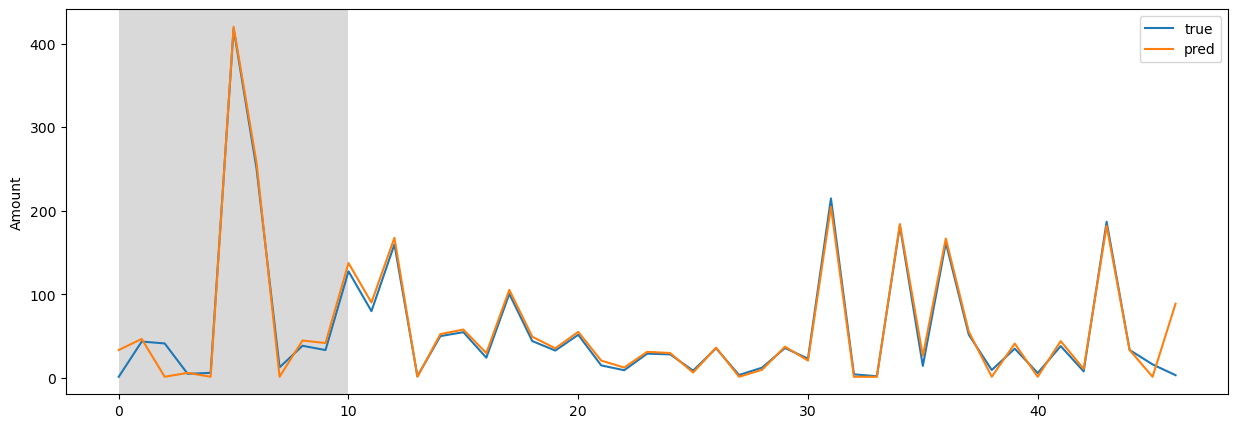

In [1484]:
plot_comparison(start_idx=0, length=300, train=True)


1/1 [==============================] - 0s 22ms/step


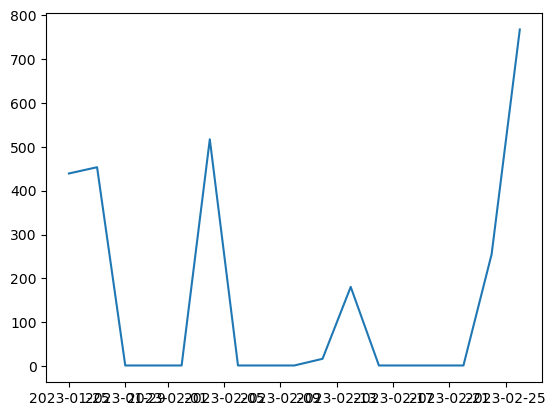

In [1486]:
recursive_predictions = []
recursive_predictions.append(list(y_test[::-1]))
for pred in range(17):
    #print(pred)
    pog=np.expand_dims(recursive_predictions,axis=0)
    #pog1 = np.expand_dims(pog,axis=0)
    #print(pog1)
    pogpred=model.predict(pog)
    poggers = y_scaler.inverse_transform(pogpred[0])
    recursive_predictions[0].append(poggers[0][0])
dates2=clean24.max()[0,0]
timelist=[]
for m in range(1,18):
    time_change = datetime.timedelta(days=2*m)
    time=dates2+time_change
    timelist.append(time)
plt.plot(timelist,recursive_predictions[0][len(y_test)::], label='pogpred')


In [1487]:
name=clean23[1,2]
clean23.write_json('~/OneDrive/Desktop/'+name+".json",row_oriented=True,pretty=True)

In [1488]:
recursive_predictions[0][len(y_test)::]

[439.17365,
 453.46545,
 1.34,
 1.34,
 1.34,
 517.19305,
 1.34,
 1.34,
 1.34,
 16.546028,
 180.5614,
 1.34,
 1.34,
 1.34,
 1.34,
 255.02791,
 767.5739]

In [1489]:
predict= pl.DataFrame(
    {"Posting Date": timelist,
    "Amount" : recursive_predictions[0][len(y_test)::]
    }
)

shape: (17, 2)
┌─────────────────────┬────────────┐
│ Posting Date        ┆ Amount     │
│ ---                 ┆ ---        │
│ datetime[μs]        ┆ f64        │
╞═════════════════════╪════════════╡
│ 2023-01-25 00:00:00 ┆ 439.173645 │
│ 2023-01-27 00:00:00 ┆ 453.465454 │
│ 2023-01-29 00:00:00 ┆ 1.34       │
│ 2023-01-31 00:00:00 ┆ 1.34       │
│ ...                 ┆ ...        │
│ 2023-02-20 00:00:00 ┆ 1.34       │
│ 2023-02-22 00:00:00 ┆ 1.34       │
│ 2023-02-24 00:00:00 ┆ 255.027908 │
│ 2023-02-26 00:00:00 ┆ 767.573914 │
└─────────────────────┴────────────┘


In [1490]:
predict.with_columns(pl.lit(name).alias('Categories'))
predict.write_json('~/OneDrive/Desktop/'+'predict'+name+".json",row_oriented=True,pretty=True)